In [17]:
""" Notebook to ingest leaf-level gas exchange and spectral data from Tumbarumba 2022
See accompanying documents:
-Materials and methods.docx
-Data collection summary.xlsx
"""

import matplotlib.pylab as plt
import os
import csv
import numpy as np
from datetime import datetime
import pandas as pd
from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import json   #  read in .json flash data
import statsmodels.api as sm       #  multiple linear regression


In [23]:
##   makes the plots interactive inline (helpful!)
%matplotlib notebook
matplotlib.interactive(True)

from matplotlib.pyplot import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

In [24]:
""" Read in data on a per leaf basis and do some basic plotting 
-update the below paths """

qep_dir = r'C:\Users\uqwwoodg\Dropbox\DECRA\!Research\leaf_level_instrument_methods_paper\QEP_field data\Tumba April\4_others\4_Min_Hamid\QEP'

licor_dir = r'C:\Users\uqwwoodg\Dropbox\DECRA\!Research\leaf_level_instrument_methods_paper\QEP_field data\Tumba April\4_others\4_Min_Hamid\LI6800'

qep_dir = '/home/hamid/SIF/sif-photo-integ/data/william_woodgate/QEP/'

licor_dir = '/home/hamid/SIF/sif-photo-integ/data/william_woodgate/LI6800/'
""" batch load files as dfs """

leaf_list = ['L1','L2','L3','L4','L5','L6','L7','L8']  # L9 excluded (LRC only)

qep_dir_list = os.listdir(qep_dir)

for leaf_base_str in leaf_list:
    if leaf_base_str == 'L2':   # can analyse one leaf at a time
        
        # QEP dfs CO2
        co2_trans_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_CO2'+ '_trans.csv'),delimiter=',',skiprows=0) # transmittance
        co2_refl_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_CO2'+'_refl.csv'),delimiter=',',skiprows=0)   # reflectance
        co2_fmin_bs_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_CO2'+'_fmin_back.csv'),delimiter=',',skiprows=0) # Fmin back
        co2_fmin_fs_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_CO2'+'_fmin_forw.csv'),delimiter=',',skiprows=0) # Fmin forw  
        co2_fmax_bs_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_CO2'+'_fmax_back.csv'),delimiter=',',skiprows=0) # Fmax back
        co2_fmax_fs_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_CO2'+'_fmax_forw.csv'),delimiter=',',skiprows=0) # Fmax forw     
        co2_fs_bs_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_CO2'+'_fs_back.csv'),delimiter=',',skiprows=0) # Fs back
        co2_fs_fs_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_CO2'+'_fs_forw.csv'),delimiter=',',skiprows=0) # Fs forw

        # Licor df CO2
        co2_li_df = pd.read_csv(os.path.join(licor_dir,leaf_base_str+'_CO2.csv'),skiprows=2,encoding= 'unicode_escape',engine='python')
        li_df_head = pd.read_csv(os.path.join(licor_dir,leaf_base_str+'_CO2.csv'),skipfooter=len(co2_li_df),encoding= 'unicode_escape',engine='python') # read in header info
        co2_li_df.columns = li_df_head.iloc[0,:].values
        
        CO2_Qin_series = round(co2_li_df.Qin,-1).astype(int).values   # rounded to reflect the setpoint 
        CO2_Ca_series = round(co2_li_df.Ca,-1).astype(int).values   # rounded to reflect the setpoint
        
        print(leaf_base_str, 'CO2:', len(CO2_Qin_series), len(co2_trans_df))

        
        # QEP dfs LRC
        LRC_trans_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_LRC'+ '_trans.csv'),delimiter=',',skiprows=0) # transmittance
        LRC_refl_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_LRC'+'_refl.csv'),delimiter=',',skiprows=0)   # reflectance
        LRC_fmin_bs_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_LRC'+'_fmin_back.csv'),delimiter=',',skiprows=0) # Fmin back
        LRC_fmin_fs_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_LRC'+'_fmin_forw.csv'),delimiter=',',skiprows=0) # Fmin forw  
        LRC_fmax_bs_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_LRC'+'_fmax_back.csv'),delimiter=',',skiprows=0) # Fmax back
        LRC_fmax_fs_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_LRC'+'_fmax_forw.csv'),delimiter=',',skiprows=0) # Fmax forw     
        LRC_fs_bs_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_LRC'+'_fs_back.csv'),delimiter=',',skiprows=0) # Fs back
        LRC_fs_fs_df = pd.read_csv(os.path.join(qep_dir,leaf_base_str+'_LRC'+'_fs_forw.csv'),delimiter=',',skiprows=0) # Fs forw

        # Licor df LRC
        LRC_li_df = pd.read_csv(os.path.join(licor_dir,leaf_base_str+'_LRC.csv'),skiprows=2,encoding= 'unicode_escape',engine='python')
        li_df_head = pd.read_csv(os.path.join(licor_dir,leaf_base_str+'_LRC.csv'),skipfooter=len(LRC_li_df),encoding= 'unicode_escape',engine='python') # read in header info
        LRC_li_df.columns = li_df_head.iloc[0,:].values
        
        LRC_Qin_series = round(LRC_li_df.Qin,-1).astype(int).values   # rounded to reflect the setpoint 
        LRC_Ca_series = round(LRC_li_df.Ca,-1).astype(int).values   # rounded to reflect the setpoint
        
        print(leaf_base_str, 'LRC:', len(LRC_Qin_series), len(LRC_trans_df))

L2 CO2: 25 25
L2 LRC: 18 18


In [25]:
""" get the QEP wls """

X_wls_3076 = pd.to_numeric(LRC_trans_df.columns[1:])
X_wls_3076

Float64Index([  344.9133,  345.70187,  346.49038,  347.27882,  348.06719,
                348.8555,  349.64374,  350.43191,  351.22002,  352.00807,
              ...
              1120.87651, 1121.58474, 1122.29288, 1123.00094,  1123.7089,
              1124.41678, 1125.12456, 1125.83226, 1126.53987, 1127.24739],
             dtype='float64', length=1044)

In [26]:
""" example Fmax plot (LRC) for a single leaf of all light levels  """

f, (ax1,ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(13.5,5))

legend_v = LRC_Qin_series
colors_list = mpl.cm.gist_rainbow(np.linspace(0,1,len(LRC_Qin_series)))  # gist_rainbow, viridis, nipy_spectral, jet

""" bs """
for n,i in enumerate(np.arange(0,len(LRC_fmax_bs_df),1)):
    ax1.plot(X_wls_3076,LRC_fmax_bs_df.iloc[n,1:], lw=0.5,c=colors_list[n],label=legend_v[n])          #   690nm


""" fs """
for n,i in enumerate(np.arange(0,len(LRC_fmax_bs_df),1)):
    ax2.plot(X_wls_3076,LRC_fmax_fs_df.iloc[n,1:],lw=0.5,c=colors_list[n],label=legend_v[n])          #   690nm


ax1.legend(title='LRC Qin (umol m-2 s-1)',ncol=4,fontsize=10,loc=9);

ax1.set_ylim(0,0.0001)
ax2.set_ylim(0,0.0001)

ax1.set_xlim(660,800)
ax2.set_xlim(660,800)

ax1.set_ylabel('Fmax bs [$\mu$W cm-2 nm-1]',size=12)
ax2.set_ylabel('Fmax fs [$\mu$W cm-2 nm-1]',size=12)
plt.savefig("/home/hamid/SIF/sif-photo-integ/data/william_woodgate/figures/test.png")




<IPython.core.display.Javascript object>

In [11]:
""" example Fs plot (LRC) for a single leaf of all light levels  """

f, (ax1,ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(13.5,5))

legend_v = LRC_Qin_series
colors_list = mpl.cm.gist_rainbow(np.linspace(0,1,len(LRC_Qin_series)))  # gist_rainbow, viridis, nipy_spectral, jet

""" bs """
for n,i in enumerate(np.arange(0,len(LRC_fs_bs_df),1)):
    ax1.plot(X_wls_3076,LRC_fs_bs_df.iloc[n,1:], lw=0.5,c=colors_list[n],label=legend_v[n])          #   690nm


""" fs """
for n,i in enumerate(np.arange(0,len(LRC_fs_bs_df),1)):
    ax2.plot(X_wls_3076,LRC_fs_fs_df.iloc[n,1:],lw=0.5,c=colors_list[n],label=legend_v[n])          #   690nm


ax1.legend(title='LRC Qin (umol m-2 s-1)',ncol=4,fontsize=10,loc=9);

ax1.set_ylim(0,0.00001)
ax2.set_ylim(0,0.00001)

ax1.set_xlim(660,800)
ax2.set_xlim(660,800)

ax1.set_ylabel('Fs bs [$\mu$W cm-2 nm-1]',size=12)
ax2.set_ylabel('Fs fs [$\mu$W cm-2 nm-1]',size=12)



<IPython.core.display.Javascript object>

Text(0, 0.5, 'Fs fs [$\\mu$W cm-2 nm-1]')

In [16]:
""" example refl and trans plot (LRC) for a single leaf of all light levels """

f, (ax1,ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(11,5))

legend_v = LRC_Qin_series
colors_list = mpl.cm.gist_rainbow(np.linspace(0,1,len(LRC_Qin_series)))  # gist_rainbow, viridis, nipy_spectral, jet

""" T """
for n,i in enumerate(np.arange(0,len(LRC_trans_df),1)):
    ax1.plot(X_wls_3076,LRC_trans_df.iloc[n,1:], lw=0.5,c=colors_list[n],label=legend_v[n])          #   690nm


""" R """
for n,i in enumerate(np.arange(0,len(LRC_trans_df),1)):
    ax2.plot(X_wls_3076,LRC_refl_df.iloc[n,1:],lw=0.5,c=colors_list[n],label=legend_v[n])          #   690nm


ax1.legend(title='LRC Qin (umol m-2 s-1)',ncol=4,fontsize=10,loc=9);

ax1.set_ylim(0,0.25)
ax2.set_ylim(0,0.25)

ax1.set_xlim(450,645)
ax2.set_xlim(450,645)

ax1.set_ylabel('Transmittance [-]',size=12)
ax2.set_ylabel('Reflectance [-]',size=12);



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


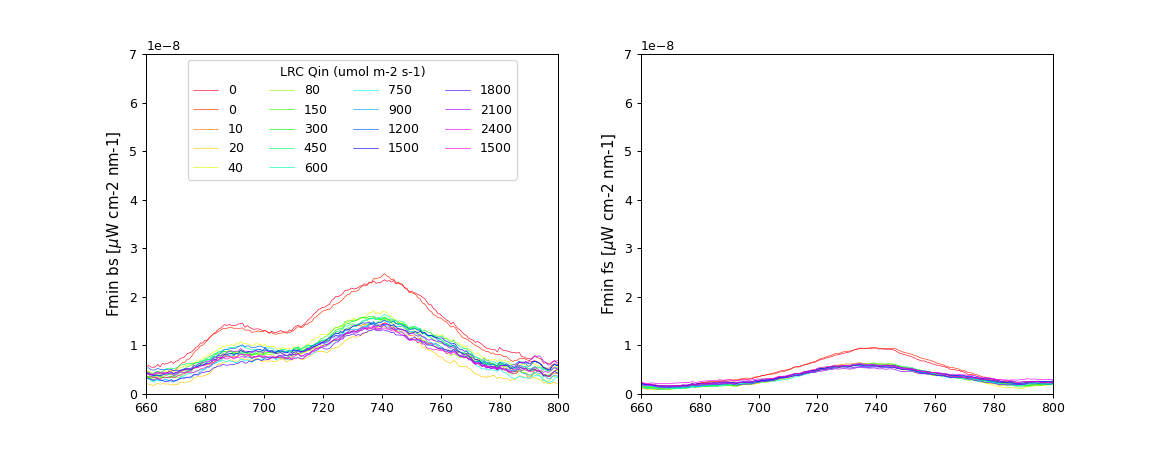

In [105]:
""" example Fmin plot (LRC) for a single leaf of all light levels
- apply smoothing
- I wouldn't recommend reading too much into this data as it's very noisy """

f, (ax1,ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(13,5))

legend_v = LRC_Qin_series
colors_list = mpl.cm.gist_rainbow(np.linspace(0,1,len(LRC_Qin_series)))  # gist_rainbow, viridis, nipy_spectral, jet

""" bs """
for n,i in enumerate(np.arange(0,len(LRC_fmax_bs_df),1)):
    ax1.plot(X_wls_3076,LRC_fmin_bs_df.iloc[n,1:].rolling(20,center=True,min_periods=1).mean()
             , lw=0.5,c=colors_list[n],label=legend_v[n])          #   690nm


""" fs """
for n,i in enumerate(np.arange(0,len(LRC_fmax_bs_df),1)):
    ax2.plot(X_wls_3076,LRC_fmin_fs_df.iloc[n,1:].rolling(20,center=True,min_periods=1).mean()
             ,lw=0.5,c=colors_list[n],label=legend_v[n])          #   690nm


ax1.legend(title='LRC Qin (umol m-2 s-1)',ncol=4,fontsize=10,loc=9);

ax1.set_ylim(0,0.00000007)
ax2.set_ylim(0,0.00000007)

ax1.set_xlim(660,800)
ax2.set_xlim(660,800)

ax1.set_ylabel('Fmin bs [$\mu$W cm-2 nm-1]',size=12)
ax2.set_ylabel('Fmin fs [$\mu$W cm-2 nm-1]',size=12);


<IPython.core.display.Javascript object>


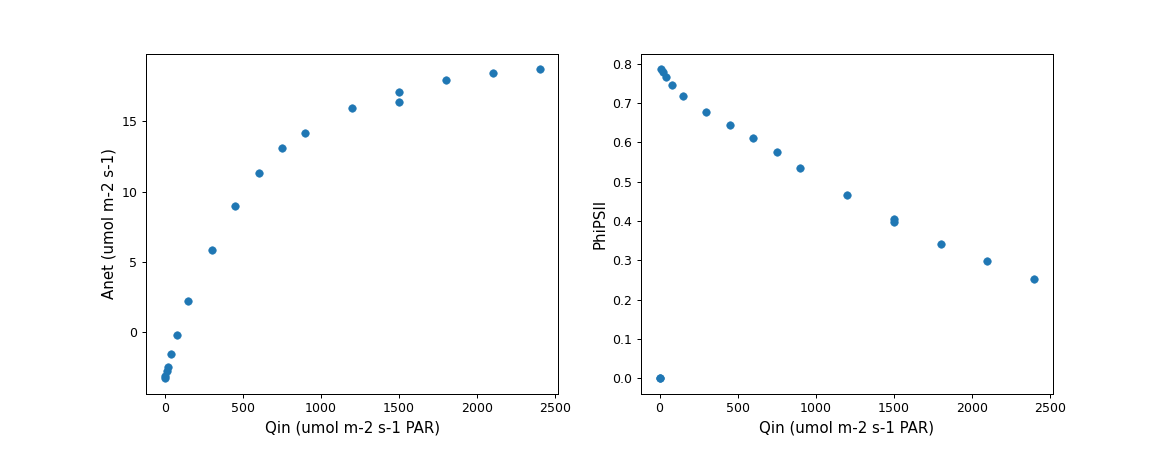

Text(0.5, 0, 'Qin (umol m-2 s-1 PAR)')

In [100]:
""" LI6800 data for a single light reponse curve """

f, (ax1,ax2) = plt.subplots(1, 2, sharey=False, sharex=False, figsize=(13,5))

legend_v = LRC_Qin_series
colors_list = mpl.cm.gist_rainbow(np.linspace(0,1,len(LRC_Qin_series)))  # gist_rainbow, viridis, nipy_spectral, jet

""" bs """
ax1.scatter(LRC_Qin_series,LRC_li_df.A, lw=0.5,label=legend_v[n])


""" fs """
ax2.scatter(LRC_Qin_series,pd.to_numeric(list(map(lambda item: item.replace('#DIV/0!','0'), list(LRC_li_df.PhiPS2.values)))),
            lw=0.5,label=legend_v[n])


#ax1.legend(title='LRC Qin (umol m-2 s-1)',ncol=4,fontsize=10,loc=9);


ax1.set_ylabel('Anet (umol m-2 s-1)',size=12)
ax2.set_ylabel('PhiPSII',size=12);

ax1.set_xlabel('Qin (umol m-2 s-1 PAR)',size=12)
ax2.set_xlabel('Qin (umol m-2 s-1 PAR)',size=12)

In [22]:
Ca_series

array([ 400,    0,   50,  100,  150,  200,  250,  300,  350,  400,  600,
        800, 1000, 1200, 1400, 1600, 1800, 2000,  400,  400,  400,  400,
        400,  400,  400])

In [17]:
co2_li_df.head()

,obs,time,elapsed,date,hhmmss,TIME,E,A,Ca,Ci,...,Ts,Tr,CO2_%,Desiccant_%,Humidifier_%,Txchg_sp,CO2_r_sp,H2O_r_sp,SS_s,SS_r
0,19,1649159961,6490.5,20220405 21:59:20,21:59:20,1649159953,0.002740,14.740240,400.014290,284.547271,...,23.4667,23.4434,21.19440,16.4187,91.0971,25.1905,406.4050,21.6479,98.9206,101.845
1,20,1649160286,6816.0,20220405 22:04:46,22:04:46,1649160278,0.002590,-4.995999,1.286019,39.716492,...,23.4334,23.4062,0.00000,16.1335,95.6214,25.0612,404.2140,21.6566,98.9315,101.851
2,21,1649160617,7147.0,20220405 22:10:17,22:10:17,1649160609,0.002515,-2.216410,49.972967,66.715724,...,23.4020,23.3750,5.45760,16.2601,98.9670,25.2637,49.0952,21.6217,98.9421,101.858
3,22,1649160941,7471.0,20220405 22:15:41,22:15:41,1649160933,0.002427,0.243589,99.938943,95.892060,...,23.3414,23.3141,7.70406,15.9748,100.0000,25.2372,100.0780,21.6434,98.9573,101.873
4,23,1649161277,7806.6,20220405 22:21:16,22:21:16,1649161269,0.002314,2.127087,150.001900,128.443247,...,23.2789,23.2516,10.05650,14.4237,100.0000,25.2520,151.0030,21.7607,98.9632,101.881


In [8]:
""" preview the transmittance df """
# first col is the index of measurement
# second col is the time of measurement (seconds since 1970)
# the other cols are the spectral data with the column header the central band

trans_df.head()

,dt,344.9133,345.70187,346.49038,347.27882,348.06719,348.8555,349.64374,350.43191,351.22002,...,1120.87651,1121.58474,1122.29288,1123.00094,1123.7089,1124.41678,1125.12456,1125.83226,1126.53987,1127.24739
0,2.371501e+10,-0.002557,-0.073794,-0.000807,-0.244489,0.024009,-0.025774,0.007344,0.006189,0.003088,...,0.681820,0.671826,0.863799,0.620933,0.562852,0.817068,-0.012663,0.081730,-0.078941,0.039770
1,2.403342e+10,-0.002669,-0.232826,0.136135,-0.358750,0.104509,-0.155856,-0.001063,-0.007974,0.019022,...,0.691458,0.694731,0.842165,0.596763,0.576743,0.810470,-0.028647,0.074372,0.071280,0.061319
2,2.437327e+10,-0.003117,-0.108126,0.152278,-0.094540,0.186986,-0.181327,0.003063,-0.029085,-0.000906,...,0.689190,0.783667,0.832675,0.620213,0.559614,0.889645,-0.034459,0.132438,-0.124573,0.028382
3,2.469818e+10,0.000194,-0.374495,0.147166,-0.308976,0.046040,-0.100366,0.013157,-0.013783,-0.001441,...,0.723321,0.741321,0.886967,0.593574,0.601914,0.884274,-0.012248,0.112354,-0.064951,0.051333
4,2.502929e+10,-0.002383,-0.199678,0.117840,-0.349985,0.139533,-0.040632,0.000563,-0.024528,0.002388,...,0.694633,0.697859,0.841607,0.591414,0.560450,0.807401,-0.019513,0.100621,-0.028645,0.085846
